<a href="https://colab.research.google.com/github/jakedorman64/internship/blob/main/Double_Pendulum_NeuralODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Double Pendulum Simulator

Solving the Euler Lagrange equations for the double pendulum gives the second order differential equations:

$$ \begin{align} \ddot{\theta}_1 & = \frac{g \sin{\theta_2} \cos{(\theta_1 - \theta_2)} - \sin{(\theta_1 - \theta_2)} \left[ \dot{\theta}_1^2 \cos{(\theta_1 - \theta_2)} + \dot{\theta}_2^2\right] - 2 g \sin{\theta_1}}{1 + \sin^2{(\theta_1 - \theta_2)}}
\\
 \ddot{\theta}_2 & = \frac{2 \left[ \dot{\theta}_1^2 \sin{(\theta_1 - \theta_2)} - g \sin{\theta_2} + g \sin{\theta_1} \cos {(\theta_1 - \theta_2)} \right] + \dot{\theta}_2^2 \sin{(\theta_1 - \theta_2)} \cos{(\theta_1 - \theta_2)}}{1 + \sin^2{(\theta_1 - \theta_2)}} \end{align} $$

Note that we have set mass and length of both sections to be 1. We need a system of first order differential equations. Thus, we will define $ \omega = \dot{\theta} $ for each section, thus giving us the system of equations:

$$ \begin{align} \frac{d \omega_1}{dt} & = \frac{g \sin{\theta_2} \cos{(\theta_1 - \theta_2)} - \sin{(\theta_1 - \theta_2)} \left[ \omega_1^2 \cos{(\theta_1 - \theta_2)} + \omega_2^2\right] - 2 g \sin{\theta_1}}{1 + \sin^2{(\theta_1 - \theta_2)}}
\\
 \frac{d \omega_2}{dt} & = \frac{2 \left[ \omega_1^2 \sin{(\theta_1 - \theta_2)} - g \sin{\theta_2} + g \sin{\theta_1} \cos {(\theta_1 - \theta_2)} \right] + \omega_2^2 \sin{(\theta_1 - \theta_2)} \cos{(\theta_1 - \theta_2)}}{1 + \sin^2{(\theta_1 - \theta_2)}} \end{align} $$
 Plus the simpler equations:
 $$\begin{align} \frac{d \theta_1}{dt} & = \omega_1 \\ \frac{d \theta_2}{dt} & = \omega_2. \end{align} $$

#Generate the Data

In [129]:
!pip install git+https://github.com/deepmind/dm-haiku

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-q_viqfyq
  Running command git clone --filter=blob:none --quiet https://github.com/deepmind/dm-haiku /tmp/pip-req-build-q_viqfyq
  Resolved https://github.com/deepmind/dm-haiku to commit f6439a1a234f1c46f0d515ade42de6f47553e7ef
  Preparing metadata (setup.py) ... done
  Created wheel for dm-haiku: filename=dm_haiku-0.0.10.dev0-py3-none-any.whl size=360287 sha256=e8b5b34730505517dd0cb9f96ee738fade0ad06b27217fe862cef783fa39caaa
  Stored in directory: /tmp/pip-ephem-wheel-cache-d109jcpp/wheels/b1/df/f1/a357fa8f00c36052bdae1e1fd363650c0bd1e8c3959487b6fb
Successfully built dm-haiku


In [244]:
from typing import Iterator, NamedTuple
import jax
import jax.numpy as jnp
from jax.numpy import pi, sin, cos
from jax import value_and_grad, jit
from jax import random
from jax.experimental.ode import odeint
from jax.config import config
import matplotlib.pyplot as plt
import imageio
import time
from tqdm.auto import trange
from matplotlib.patches import Circle
from functools import partial
from sklearn.model_selection import train_test_split
import haiku as hk
import optax
import numpy as np

config.update("jax_disable_jit", False)

# Define gravity
g = - 9.81
dt = 0.01
data_points = 1024
batch_size = 16
total_time = data_points * dt
gradient_updates = 20000

In [245]:
@jit
def dy_dt(y, t, g):
  # Create return array and unpack the values of y:

  theta_1 = y[0]
  theta_2 = y[1]
  omega_1 = y[2]
  omega_2 = y[3]

  # Make the equations nicer by setting these:
  s = sin(theta_1 - theta_2)
  c = cos(theta_1 - theta_2)

  # Derivative of the thetas are just the omegas:
  dtheta1_dt = omega_1
  dtheta2_dt = omega_2

  # Derivative of the omegas:
  domega1_dt = ( g * sin(theta_2) * c - s * ((omega_1 ** 2) * c + (omega_2 ** 2)) - 2 * g * sin(theta_1) ) / (1 + s ** 2)

  domega2_dt = ( 2 * ( (omega_1 ** 2) * s - g * sin(theta_2) + g * sin(theta_1) * c ) + (omega_2 ** 2) * s * c ) / (1 + s ** 2)

  dy_dt = jnp.array([dtheta1_dt, dtheta2_dt, domega1_dt, domega2_dt])
  return dy_dt

In [246]:
# Generate our initial datapoint.
key, subkey = random.split(random.PRNGKey(int(time.time())))
theta_1_init = random.uniform(key, minval = - pi, maxval = pi)
theta_2_init = random.uniform(subkey, minval = - pi, maxval = pi)

key, subkey = random.split(key)
# omega_1_init = random.uniform(key, minval = -10, maxval = 10)
# omega_2_init = random.uniform(key, minval = -10, maxval = 10)

omega_1_init = 0
omega_2_init = 0

init = jnp.array([theta_1_init, theta_2_init, omega_1_init, omega_2_init])

# And generate our time array:
tsteps = jnp.linspace(0, int(total_time), data_points)

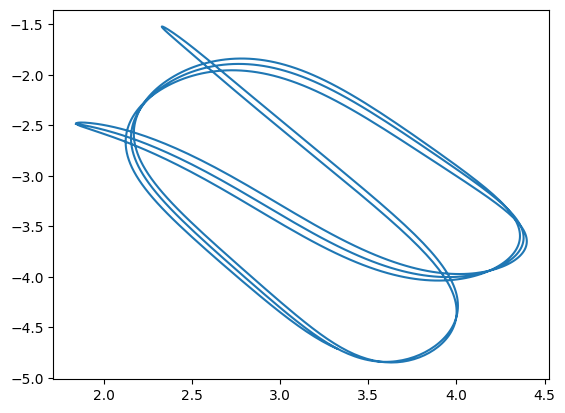

In [247]:
# Generate our data:
generated_data = odeint(dy_dt, init, tsteps, g)

plt.plot(generated_data[:, 0], generated_data[:, 1])

theta_1 = generated_data[:, 0]
theta_2 = generated_data[:, 1]

In [248]:
# Normalise the angles by dividing by pi, and the velocity by dividing by 100.
def modulo_pi(x):
  return x % pi

# Normalise our generated data. We do this by modulo-ing the angles by pi and then dividing bby pi, and dividing the angular velocities by 100.
normalised_data = generated_data
normalised_data = normalised_data.at[:,:2].apply(modulo_pi)
normalised_data = normalised_data.at[:,:2].divide(pi)
normalised_data = normalised_data.at[:,2:].divide(100)

# Split the data. We need shuffle to be 0 to preserve the time series.
x_train, x_test, y_train, y_test = train_test_split(tsteps, normalised_data, shuffle=False, stratify=None, random_state=42)

# Build The Model

In [249]:
# Define our dataset class. This allows us to batch our data when training.
class Dataset:
  """An iterator over a numpy array, revealing batch_size elements at a time."""
  # Initialise our dataset class. It needs the full x and y values and a batch size to be initialised.
  def __init__(self, x: jnp.array, y: jnp.array, batch_size: int):
    self._x = x
    self._y = y
    self._batch_size = batch_size
    self._length = self._x.shape[0]
    # The id stores where the next datapoint should be taken from, so when initialised it should be 0.
    self._idx = 0
    if self._length % batch_size != 0:
      msg = 'dataset size {} must be divisible by batch_size {}.'
      raise ValueError(msg.format(self._length, batch_size))

  # This is the function that gives us our next batch of data.
  def __next__(self):
    # Select the first and last datapoints in the batch. First will be the current value of the ID
    start = self._idx
    end = start + self._batch_size
    # Select our data.
    x, y = self._x[start:end], self._y[start:end]
    # This resets us back to 0 once we reach the end of our data.
    if end >= self._length:
      end = end % self._length
      # assert end == 0  # Guaranteed by ctor assertion.
    self._idx = end
    return x, y

In [250]:
# Now that we have defined our dataset class, we can make our datasets:
train_dataset = Dataset(x_train, y_train, batch_size)
eval_dataset = Dataset(x_test, y_test, batch_size)

In [251]:
# Define a batch of data.
class Batch(NamedTuple):
  input: np.ndarray
  output: np.ndarray

# Define a training state, telling us what parameters we have and the state of the optimizer.
class TrainingState(NamedTuple):
  params: hk.Params
  opt_state: optax.OptState

In [258]:
# Define the neural network.
def FeedForward(x):
  mlp = hk.Sequential([
      hk.Linear(10), jax.nn.relu,
      hk.Linear(10), jnp.sinc,
      hk.Linear(4),
  ])
  return mlp(x)

# Define our network and optimiser.
network = hk.without_apply_rng(hk.transform(FeedForward))
optimiser = optax.adam(1e-2)

In [269]:
# Define our mean squared error loss.
# The jits are hashed out because if it is jitted it does not print the actual data, it just prints the datatype, which does not help when debugging.
@jit
def nn_predict(y, t, weights):
  return network.apply(weights, y)

@jit
def MeanSquaredErrorLoss(weights, batch):
  # Flatten our x inputs.
  tsteps = batch[0].flatten()
  ybatch = batch[1]

  # Make our predictions.
  preds = odeint(nn_predict, ybatch[0], tsteps, weights)

  # This removes the fact that it is an array of arrays. Also, we do not need the initial value of 0.
  preds = preds.squeeze()[1:]

  return jnp.power(ybatch[1:,:2] - preds[:,:2], 2).mean()

In [264]:
@jit
def update(state: TrainingState, batch: Batch) -> TrainingState:
  # This is how we define our stochastic gradient descent.

  # Find grads of loss w.r.t parameters, on this batch of the data
  grads = jax.grad(MeanSquaredErrorLoss)(state.params, batch)
  # Get the updates and the new optimser state from this.
  updates, opt_state = optimiser.update(grads, state.opt_state)
  # Apply the updates to the parameters.
  params = optax.apply_updates(state.params, updates)

  #return the training state with the new parameters and the optimiser.
  return TrainingState(params, opt_state)

In [265]:
#Initialising the parameters randomly.
rng = jax.random.PRNGKey(12)
initial_params = network.init(rng, y_train[1])

# Initialise the optimiser and the define the state.
initial_opt_state = optimiser.init(initial_params)
state = TrainingState(initial_params, initial_opt_state)

# Print the structure of the network.
print("Weights Type : {}\n".format(type(initial_params)))

for layer_name, weights in initial_params.items():
    print(layer_name)
    print("Weights : {}, Biases : {}\n".format(initial_params[layer_name]["w"].shape,initial_params[layer_name]["b"].shape))

Weights Type : <class 'dict'>

linear
Weights : (4, 10), Biases : (10,)

linear_1
Weights : (10, 10), Biases : (10,)

linear_2
Weights : (10, 4), Biases : (4,)



In [266]:

# Training & evaluation loop.
train_loss_list = []
val_loss_list = []
for step in range(gradient_updates):
  # Do stochastic gradient descent on a batch of training examples.
  state = update(state, next(train_dataset))

  # Print the training and evaluation loss every 1000 time steps.
  if step % 1000 == 0:
    train_loss_list.append(MeanSquaredErrorLoss(state.params, next(train_dataset)))
    val_loss_list.append(MeanSquaredErrorLoss(state.params, next(eval_dataset)))
    print("Step {}: train loss {}, eval loss {}".format(step, train_loss_list[-1], val_loss_list[-1]))

plt.plot(train_loss_list, color="b")
plt.plot(val_loss_list, color="red")

Step 0: train loss 0.010969147086143494, eval loss 0.009597529657185078
Step 1000: train loss 0.10459291189908981, eval loss 0.017972303554415703
Step 2000: train loss 0.049447592347860336, eval loss 0.27396321296691895
Step 3000: train loss 0.0025945587549358606, eval loss 0.0004572591569740325
Step 4000: train loss 0.0016025567892938852, eval loss 0.003309203777462244
Step 5000: train loss 0.005925956182181835, eval loss 0.0008244943455792964


KeyboardInterrupt: ignored

In [ ]:
generated_data = odeint(nn_predict, init, tsteps, state.params)
plt.plot(normalised_data[:, 0], normalised_data[:, 1], color="red", label="Truth")
plt.plot(generated_data[:, 0], generated_data[:, 1], color="blue", label="Predicted")


# Create animation of the pendulums

In [81]:
 # Computes a plot of the angles.

plt.plot(theta_1, c='b')
plt.plot(theta_2, c='r')

plt.plot(theta_1, theta_2)

NameError: ignored

Code below will convert the data into a gif.

0 / 102
1 / 102
2 / 102
3 / 102
4 / 102
5 / 102
6 / 102
7 / 102
8 / 102
9 / 102
10 / 102
11 / 102
12 / 102
13 / 102
14 / 102
15 / 102
16 / 102
17 / 102
18 / 102
19 / 102
20 / 102
21 / 102
22 / 102
23 / 102
24 / 102
25 / 102
26 / 102
27 / 102
28 / 102
29 / 102
30 / 102
31 / 102
32 / 102
33 / 102
34 / 102
35 / 102
36 / 102
37 / 102
38 / 102
39 / 102
40 / 102
41 / 102
42 / 102
43 / 102
44 / 102
45 / 102
46 / 102
47 / 102
48 / 102
49 / 102
50 / 102
51 / 102
52 / 102
53 / 102
54 / 102
55 / 102
56 / 102
57 / 102
58 / 102
59 / 102
60 / 102
61 / 102
62 / 102
63 / 102
64 / 102
65 / 102
66 / 102
67 / 102
68 / 102
69 / 102
70 / 102
71 / 102
72 / 102
73 / 102
74 / 102
75 / 102
76 / 102
77 / 102
78 / 102
79 / 102
80 / 102
81 / 102
82 / 102
83 / 102
84 / 102
85 / 102
86 / 102
87 / 102
88 / 102
89 / 102
90 / 102
91 / 102
92 / 102
93 / 102
94 / 102
95 / 102
96 / 102
97 / 102
98 / 102
99 / 102
100 / 102
101 / 102
102 / 102


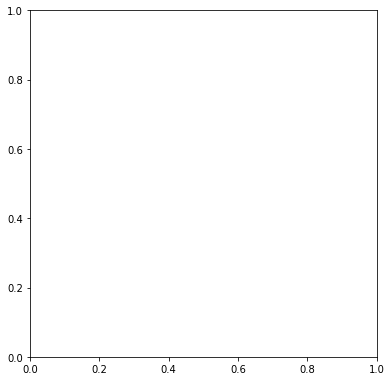

In [124]:
# Convert to Cartesian coordinates of the two bob positions.
x1 = sin(theta_1)
y1 = cos(theta_1)
x2 = x1 + sin(theta_2)
y2 = y1 + cos(theta_2)

# Plotted bob circle radius
r = 0.05
# Plot a trail of the m2 bob's position for the last trail_secs seconds.
trail_secs = 1
# This corresponds to max_trail time points.
max_trail = int(trail_secs / dt)

def make_plot(i):
    # Plot and save an image of the double pendulum configuration for time
    # point i.
    # The pendulum rods.
    ax.plot([0, x1[i], x2[i]], [0, y1[i], y2[i]], lw=2, c='k')
    # Circles representing the anchor point of rod 1, and bobs 1 and 2.
    c0 = Circle((0, 0), r/2, fc='k', zorder=10)
    c1 = Circle((x1[i], y1[i]), r, fc='b', ec='b', zorder=10)
    c2 = Circle((x2[i], y2[i]), r, fc='r', ec='r', zorder=10)
    ax.add_patch(c0)
    ax.add_patch(c1)
    ax.add_patch(c2)

    # The trail will be divided into ns segments and plotted as a fading line.
    ns = 20
    s = max_trail // ns

    for j in range(ns):
        imin = i - (ns-j)*s
        if imin < 0:
            continue
        imax = imin + s + 1
        # The fading looks better if we square the fractional length along the
        # trail.
        alpha = (j/ns)**2
        ax.plot(x2[imin:imax], y2[imin:imax], c='r', solid_capstyle='butt',
                lw=2, alpha=alpha)

    # Centre the image on the fixed anchor point, and ensure the axes are equal
    ax.set_xlim(-2-r, 2+r)
    ax.set_ylim(-2-r, 2+r)
    ax.set_aspect('equal', adjustable='box')
    plt.axis('off')
    plt.savefig('img{:04d}.png'.format(i//di), dpi=72)
    plt.plot()
    plt.cla()


# Make an image every di time points, corresponding to a frame rate of fps
# frames per second.
# Frame rate, s-1
fps = 10
di = int(1/fps/dt)
fig = plt.figure(figsize=(8.3333, 6.25), dpi=72)
ax = fig.add_subplot(111)

for i in range(0, tsteps.size, di):
    print(i // di, '/', tsteps.size // di)
    make_plot(i)

In [125]:
frames = []
for i in range(int(tsteps.size) // di):
  image = imageio.v2.imread(f'img{i:04}.png')
  frames.append(image)

imageio
imageio.mimsave('./example.gif', # output gif
                frames,          # array of input frames
                fps = 10)         # optional: frames per second """

